In [67]:
! pip install scipy

  Using cached scipy-1.12.0-cp312-cp312-macosx_10_9_x86_64.whl.metadata (60 kB)
Using cached scipy-1.12.0-cp312-cp312-macosx_10_9_x86_64.whl (38.9 MB)


In [2]:
from Bio import AlignIO
import os
import multiprocessing
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from scipy.optimize import differential_evolution

Экстракция данных из файла с геномами и создание датафрейма

In [2]:
def process_info_files(genomes_csv, lst_info_file):
    """
    Process information files to extract relevant data for further analysis.

    Args:
        genomes_csv (str): Path to the CSV file containing genome information.
        lst_info_file (str): Path to the LSTINFO file containing additional information.

    Returns:
        pandas.DataFrame: Processed DataFrame containing necessary information.
    """
    genome_names = pd.read_csv(genomes_csv, sep='\t', header=None).rename(columns={0:'GCF', 1:'species', 2:'strain'})
    genome_names['strain'] = genome_names['strain'].str[len('strain='):]
    genome_names['strain'] = genome_names['strain'].fillna(0)

    lst_info = pd.read_csv(lst_info_file, sep='\t')
    lst_info['GCF'] = lst_info['orig_name'].str.extract(r'(GCF\_\d{9}\.\d{1})', expand=True)

    data_1 = lst_info[['gembase_name', 'GCF']]
    data_2 = pd.merge(data_1, genome_names, on='GCF')

    return data_2

Создаем датафрейм с последовательностями генов.

In [3]:
def convert_fasta_to_dataframe(file_name):
    """
    Convert a FASTA file to a pandas DataFrame.

    Args:
        file_name (str): Path to the input FASTA file.

    Returns:
        pandas.DataFrame: DataFrame containing gene sequences and related information.
    """
    dic = {}
    cur_scaf = ''
    cur_seq = []

    for line in open(file_name):
        if line.startswith(">") and cur_scaf == '':
            cur_scaf = line.split(' ')[0][1:]
        elif line.startswith(">") and cur_scaf != '':
            dic[cur_scaf] = ''.join(cur_seq)
            cur_scaf = line.split(' ')[0][1:]
            cur_seq = []
        else:
            cur_seq.append(line.rstrip())

    dic[cur_scaf] = ''.join(cur_seq)

    names = dic.keys()
    seqs = dic.values()

    genes_dict = {'name': names, 'gene': seqs}
    genes_df = pd.DataFrame.from_dict(genes_dict)
    genes_df['gembase_name'] = genes_df['name'].str.extract(r'(STRP\.0423\.\d{5})', expand=True)

    return genes_df


Смердживаем два датафрейма с предыдущих шагов

In [ ]:
def process_dataframes(genes_df, data_2):
    """
    Process DataFrames containing gene sequences and additional information.

    Args:
        genes_df (pandas.DataFrame): DataFrame containing gene sequences.
        data_2 (pandas.DataFrame): DataFrame containing additional information.

    Returns:
        pandas.DataFrame: Processed DataFrame with merged data.
    """
    input_table = pd.merge(genes_df, data_2, on='gembase_name')
    input_table = input_table[['name', 'GCF', 'species', 'strain', 'gene']]
    input_table = input_table[~input_table['species'].str.contains(' sp.')]

    return input_table

Поиск мисмэтчей в попарных выравниваниях.

In [4]:
def find_mismatches(output_folder):
    mismatches_data = []

    # Проходим по всем файлам в папке output_folder
    for filename in os.listdir(output_folder):
        if filename.endswith('.fas'):
            aligned_file = os.path.join(output_folder, filename)
            
            # Открываем файл с выравниванием
            alignment = AlignIO.read(aligned_file, 'fasta')
            
            # Получаем длину выравнивания
            alignment_length = alignment.get_alignment_length()

            # Разделяем длину на 20 сегментов
            segment_length = alignment_length // 20

            # Проходим по выравниванию с окном длиной segment_length
            for i in range(0, alignment_length, segment_length):
                # Инициализируем счетчик мисматчей для текущего сегмента
                mismatch_count = 0

                # Проходим по каждой позиции в сегменте и сравниваем символы в выравниваниях
                for j in range(segment_length):
                    # Проверяем, что индексы не выходят за пределы длины выравнивания
                    if i + j < alignment_length:
                        # Получаем символы из каждого выравнивания
                        symbol1 = alignment[0, i + j]
                        symbol2 = alignment[1, i + j]
                        
                        # Если символы не совпадают, увеличиваем счетчик мисматчей
                        if symbol1 != symbol2:
                            mismatch_count += 1
                
                # Вычисляем количество мисмэтчей в текущем сегменте, поделенное на длину сегмента
                mismatch_ratio = mismatch_count / segment_length * 100

                # Добавляем данные о мисматчах для текущего сегмента в список
                mismatches_data.append({'File': filename,
                                        'Segment': i // segment_length + 1,
                                        'Mismatch_Count': mismatch_ratio})
    
    # Создаем DataFrame из списка словарей
    df = pd.DataFrame(mismatches_data)
    
    # Переворачиваем таблицу так, чтобы сегменты были столбцами
    df = df.pivot(index='File', columns='Segment', values='Mismatch_Count')
    
    return df

Создаем отдельную папку с парами генов по каждому условию. 

In [5]:
def create_gene_pairs_folders(condition_rows, selection_condition):
    """
    Create folders and save gene pairs based on specified conditions.

    Args:
        condition_rows (pandas.DataFrame): DataFrame containing gene pairs.
        selection_condition (str): Selection condition for filtering gene pairs.
    """
    # Создаем папку для сохранения пар
    output_folder = f"{selection_condition.replace(' ', '_')}_pairs"
    os.makedirs(output_folder, exist_ok=True)

    # Получаем количество строк в DataFrame
    num_rows = len(condition_rows)

    # Проходим по каждой строке в DataFrame
    for i in range(num_rows):
        for j in range(i + 1, num_rows):
            # Получаем значения из пары
            name1, name2 = condition_rows.iloc[i]['name'], condition_rows.iloc[j]['name']
            gcf1, gcf2 = condition_rows.iloc[i]['GCF'], condition_rows.iloc[j]['GCF']

            # Проверяем, что значения из пары не совпадают и GCF у пары разные
            if name1 != name2 and gcf1 != gcf2:
                # Форматируем текст и создаем имя файла
                row1 = condition_rows.iloc[i]
                row2 = condition_rows.iloc[j]
                
                # Заменяем пробелы на нижнее подчеркивание
                species1 = row1['species'].replace(' ', '_')
                species2 = row2['species'].replace(' ', '_')

                formatted_text = f">{row1['name']}_{row1['GCF']}_{species1}_{row1['strain']}\n{row1['gene']}\n"
                formatted_text += f">{row2['name']}_{row2['GCF']}_{species2}_{row2['strain']}\n{row2['gene']}\n"
                
                # Создаем имя файла
                filename = f"{output_folder}/{row1['name']}-{row2['name']}.fasta"

                # Сохраняем пару в файл
                with open(filename, 'w') as file:
                    file.write(formatted_text)

Создаем новую папку, куда записываем попарные выравнивания.

In [6]:
def align_sequences(input_folder, output_folder):
    """
    Align gene sequences using the PRANK algorithm with codon-based alignment.

    Args:
        input_folder (str): Path to the folder containing input FASTA files.
        output_folder (str): Path to the folder for saving aligned sequences.
    """
    # Проверяем, существует ли уже папка с выравниваниями
    if os.path.exists(output_folder):
        print(f"Folder {output_folder} already exists. Skipping alignment.")
        # Если папка существует, переходим сразу к поиску мисмэтчей
        find_mismatches(output_folder)
        return

    os.makedirs(output_folder, exist_ok=True)
    
    # Определяем количество доступных процессоров
    num_processors = multiprocessing.cpu_count()
    
    # Создаем пул процессов
    pool = multiprocessing.Pool(processes=num_processors)
    
    # Получаем список файлов в папке
    files = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith('.fasta')]
    
    # Запускаем выравнивание для каждого файла в пуле процессов
    for filename in files:
        input_path = filename
        output_path = os.path.join(output_folder, f"aligned_{os.path.basename(filename)}")

        command = f"prank -d={input_path} -o={output_path} -codon"
        os.system(command)
    
    # Завершаем работу пула процессов
    pool.close()
    pool.join()
    
    # После каждого выравнивания вызываем функцию для анализа мисмэтчей
    find_mismatches(output_folder)

Строим графики с мисмэтчами

In [60]:
def mismatch_imaging(file_name:str):
    df = pd.read_csv(file_name)
    df.name = file_name[:-len('_mismatches.csv')]

    condition = f'{df.name}'
    folder_name = f'{condition}_plots'
    os.makedirs(folder_name, exist_ok=True)

    # Найдем максимальное значение на всем диапазоне графиков для установки общего предела оси y
    max_value = df.iloc[:, 1:].max().max()

    for index, row in df.iterrows():
        # Получим название из первого столбца
        title = row.iloc[0]

        # Получим значения точек из остальных столбцов
        values = row.iloc[1:].values

        # Сгенерируем список с номерами точек
        indexes = list(range(1, len(values) + 1))

        # Создаем график
        plt.plot(indexes, values, marker='o')

        # Подписали оси и заголовки графика
        plt.xlabel('Number of windows size=20')
        plt.ylabel('Mismatch Ratio % (Mismatch Count / Segment Length)')
        plt.title(f'{title}')

        # Установим общий предел для оси y
        plt.ylim(0, max_value)
        plt.xticks(range(1, 22))

        filename = f'{folder_name}/{title[len('aligned_'):-len('.fasta')]}.png'
        plt.savefig(filename)

        # Очистим текущую фигуру
        plt.clf()

Функция, запускающая тул

In [ ]:
def detect_phase_variations(genomes_csv, lst_info_file, fasta_file, selection_condition):
    """
    Detect phase variations in gene sequences based on specified conditions.

    Args:
        genomes_csv (str): Path to the CSV file containing genome information.
        lst_info_file (str): Path to the LSTINFO file containing additional information.
        fasta_file (str): Path to the FASTA file containing gene sequences.
        selection_condition (str or list of str): Selection condition(s) for filtering gene pairs.
    """
    data_2 = process_info_files(genomes_csv, lst_info_file)
    genes_df = convert_fasta_to_dataframe(fasta_file)
    input_table = process_dataframes(genes_df, data_2)

    if isinstance(selection_condition, list):
        for condition in selection_condition:
            condition_rows = input_table[input_table['species'].str.contains(condition, na=False)]
            create_gene_pairs_folders(condition_rows, condition)
            input_folder = f"{condition.replace(' ', '_')}_pairs"
            output_folder = f"{condition.replace(' ', '_')}_pairs_aligned"
            align_sequences(input_folder, output_folder)
            mismatches_df = find_mismatches(output_folder)
            mismatches_df.to_csv(f'{condition}_mismatches.csv', index=True)
            mismatch_imaging(f'{condition}_mismatches.csv')
    else:
        condition_rows = input_table[input_table['species'].str.contains(selection_condition, na=False)]
        create_gene_pairs_folders(condition_rows, selection_condition)
        input_folder = f"{selection_condition.replace(' ', '_')}_pairs"
        output_folder = f"{selection_condition.replace(' ', '_')}_pairs_aligned"
        align_sequences(input_folder, output_folder)
        mismatches_df = find_mismatches(output_folder)
        mismatches_df.to_csv(f'{selection_condition}_mismatches.csv', index=True)
        mismatch_imaging(f'{selection_condition}_mismatches.csv')

## Функция, определяющая вариацию

In [3]:
pneumonia = pd.read_csv('Streptococcus_pneumoniae_mismatches.csv')
gordonii = pd.read_csv('Streptococcus_gordonii_mismatches.csv')
porcinus = pd.read_csv('Streptococcus_porcinus_mismatches.csv')

In [4]:
pneumonia

,File,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,aligned_STRP.0423.00004.0001i_01903-STRP.0423....,0.000000,0.000000,0.000000,0.800000,8.000000,11.200000,0.800000,4.000000,2.400000,...,1.600000,0.000000,0.800000,0.800000,0.000000,0.800000,0.800000,1.600000,0.000000,0.000000
1,aligned_STRP.0423.00004.0001i_01903-STRP.0423....,34.636872,22.905028,31.284916,25.698324,53.072626,42.458101,79.329609,83.798883,83.798883,...,75.418994,82.681564,87.150838,92.737430,100.000000,62.011173,79.888268,82.681564,63.128492,2.234637
2,aligned_STRP.0423.00004.0001i_01903-STRP.0423....,30.075188,24.812030,18.796992,33.082707,18.045113,78.947368,84.210526,24.812030,3.759398,...,1.503759,0.000000,0.751880,0.751880,0.000000,18.796992,75.939850,51.127820,35.338346,12.030075
3,aligned_STRP.0423.00004.0001i_01903-STRP.0423....,4.800000,1.600000,2.400000,5.600000,8.000000,10.400000,0.000000,4.000000,2.400000,...,0.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.800000,3.200000,0.000000,0.000000
4,aligned_STRP.0423.00004.0001i_01903-STRP.0423....,35.195531,22.905028,30.726257,25.698324,53.072626,42.458101,79.329609,83.798883,83.798883,...,75.418994,82.681564,87.150838,92.737430,100.000000,62.011173,79.888268,83.240223,63.128492,2.234637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94143,aligned_STRP.0423.00803.0001i_01145-STRP.0423....,30.232558,25.581395,19.379845,24.031008,19.379845,55.813953,58.139535,25.581395,7.751938,...,39.534884,32.558140,25.581395,36.434109,30.232558,34.883721,83.720930,44.961240,41.085271,10.852713
94144,aligned_STRP.0423.00803.0001i_01145-STRP.0423....,40.449438,20.786517,30.898876,25.842697,60.112360,37.640449,93.820225,66.853933,68.539326,...,73.595506,78.089888,76.404494,75.280899,82.022472,62.921348,88.202247,78.651685,90.449438,0.561798
94145,aligned_STRP.0423.00803.0001i_01145-STRP.0423....,70.491803,100.000000,73.770492,95.901639,68.852459,72.131148,77.868852,100.000000,90.983607,...,100.000000,100.000000,60.655738,75.409836,79.508197,91.803279,100.000000,86.065574,82.786885,5.737705
94146,aligned_STRP.0423.00803.0001i_01145-STRP.0423....,22.834646,10.236220,2.362205,22.834646,18.110236,56.692913,62.204724,29.133858,8.661417,...,37.795276,33.858268,23.622047,35.433071,30.708661,31.496063,85.826772,32.283465,36.220472,14.960630


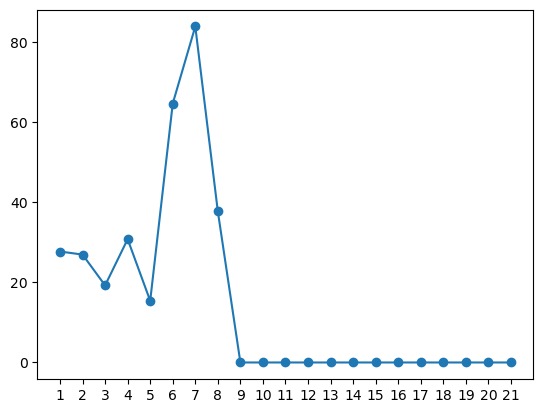

In [229]:
row = pneumonia.query("File == 'aligned_STRP.0423.00242.0001i_01233-STRP.0423.00473.0001i_01199.fasta.best.fas'").dropna(axis=1)
row_values = list(row.iloc[0, 1:])
indexes = list(range(1, len(row_values) + 1))

# Создаем график
plt.plot(indexes, row_values, marker='o')
plt.xticks(indexes);

Поиск глобального максимума

In [220]:
def find_global_maximum(y_values):
    x_int = np.arange(1, len(y_values)+1)

    # Интерполяция функции f(x)
    interp_f = interp1d(x_int, y_values)
    # Интерполяционная функция
    def interpolated_f(x):
        return interp_f(x)
    # Определяем функцию потерь для минимизации
    def loss(x):
        return -interpolated_f(x)

    result = differential_evolution(loss, [(1, len(y_values))])
    return round(result.x.item()), round(-result.fun, 4)

In [227]:
find_global_maximum(row_values)

(17, 100.0)

---
инсс

In [196]:
def extremum_singularity(values):
    extremums = []
    for i in range(50):
        extremums.append(find_global_maximum(values)[0])

    extr_lst = list(set(extremums))
    count = 0
    for j in range(1, len(extr_lst)):
        if extr_lst[j-1] + 1 == extr_lst[j] or extr_lst[j-1] + 2 == extr_lst[j]:
            count += 1
    return count == (len(extr_lst)-1)

Разница между `i` и `i+1` точками

In [197]:
def count_differences(values:list) -> list:
    diff = []
    for i in range(1, len(values)):
        diff.append(round(np.abs(values[i] - values[i-1]), 4))
    return diff

Проверка условия, что наибольшее расстояние лежит рядом с экстремумом

In [198]:
def max_dist_near_extr(diff:list, extr:float) -> bool:
    
    max_diff = np.max(diff)
    max_diff_index = diff.index(max_diff)+2

    closeness = [extr-3, extr+3]
    if closeness[0] < max_diff_index < closeness[1]:
        return True
    return False

Проверка на то, что функция средних минимизируется или максимизируется

In [199]:
def check_mean_dynamics(values:list, extr_idx:float) -> bool:

    means = []
    if extr_idx < (len(values) / 2):
        means = [(np.mean(values[extr_idx:extr_idx+i]), np.std(values[extr_idx:extr_idx+i])) for i in range(2, len(values)-extr_idx+1)]
    elif extr_idx > (len(values) / 2):
        means = [(np.mean(values[:i]), np.std(values[:i])) for i in range(1, extr_idx+1)]

    steps = []
    if extr_idx < (len(values) / 2):
        for j in range(len(means)):
            mean_j = means[j][0]
            std_j = means[j][1]
            mean_j_1 = means[j-1][0]
            std_j_1 = means[j-1][1]
            if (mean_j_1 + std_j_1) >= (mean_j - std_j):
                steps.append(1)

    elif extr_idx >= (len(values) / 2):
            for j in range(len(means)):
                mean_j = means[j][0]
                std_j = means[j][1]
                mean_j_1 = means[j-1][0]
                std_j_1 = means[j-1][1]
                if (mean_j_1 - std_j_1) <= (mean_j + std_j):
                    steps.append(1)
            
    return len(steps) == len(means), means


In [200]:
def less_threshhold(values:list, threshhold:int, n:int) -> bool:
    count = 0
    for value in values:
        if value < threshhold:
            count += 1 
    return count >= n

In [201]:
def more_threshhold(values:list, threshhold:int, n:int) -> bool:
    count = 0
    for value in values:
        if value > threshhold:
            count += 1 
    return count >= n

In [202]:
def find_phase_variation(values:list) -> bool:

    extr_x = find_global_maximum(values)[0]
    differences = count_differences(values)
    return extremum_singularity(values) and max_dist_near_extr(differences, extr_x) and less_threshhold(values, 20, 13) and more_threshhold(values, 70, 2)

In [38]:
mismatch_imaging('Streptococcus_gordonii_mismatches.csv')

<Figure size 640x480 with 0 Axes>

In [203]:
test_pneumonia = pneumonia.iloc[:200, :]
test_pneumonia['phase_variation'] = test_pneumonia.apply(lambda x: find_phase_variation(x[1:].dropna()), axis= 1)
l = test_pneumonia.phase_variation.to_list()

for i in range(len(l)):
    if l[i]:
        print((l[i], i+1))

/var/folders/vm/z94y22391gs_rcqtvdnlcp240000gn/T/ipykernel_39801/2749608177.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  diff.append(round(np.abs(values[i] - values[i-1]), 4))


(True, 7)
(True, 43)
(True, 60)
(True, 81)
(True, 85)
(True, 101)
(True, 110)
(True, 128)
(True, 144)
(True, 147)
(True, 158)
(True, 160)
(True, 174)
(True, 200)


/var/folders/vm/z94y22391gs_rcqtvdnlcp240000gn/T/ipykernel_39801/2406291215.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_pneumonia['phase_variation'] = test_pneumonia.apply(lambda x: find_phase_variation(x[1:].dropna()), axis= 1)


In [218]:
test_pneumonia.iloc[199, 0]

'aligned_STRP.0423.00004.0001i_01903-STRP.0423.00365.0001i_01149.fasta.best.fas'

In [69]:
gordonii['phase_variation'] = gordonii.apply(lambda x: find_phase_variation(x[1:].dropna()), axis= 1 )


/var/folders/vm/z94y22391gs_rcqtvdnlcp240000gn/T/ipykernel_39801/2749608177.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  diff.append(round(np.abs(values[i] - values[i-1]), 4))


In [49]:
mismatch_imaging('Streptococcus_porcinus_mismatches.csv')

<Figure size 640x480 with 0 Axes>

In [70]:
porcinus['phase_variation'] = porcinus.apply(lambda x: find_phase_variation(x[1:].dropna()), axis= 1 )
l = porcinus.phase_variation.to_list()

for i in range(len(l)):
    if l[i]:
        print((l[i], i+1))

/var/folders/vm/z94y22391gs_rcqtvdnlcp240000gn/T/ipykernel_39801/2749608177.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  diff.append(round(np.abs(values[i] - values[i-1]), 4))
